# Can census information predict how Americans will vote?

The aim of this notebook is to assess whether census data from contested presidential election years in the USA can be used to predict who the majority of people will vote for.

The dataset used is **US Census and Election Results (2000-2020)** and comes from [kaggle](https://www.kaggle.com/datasets/minhbtnguyen/us-census-for-election-predictions-20002020).

The dataset used contains information on : 
- average age
- average income (personal and family)
- marital status (married, separated, single)
- ethnicity
- citizenship
- language spoken at home
- level of education
- employment rate

All this information is divided into categories and percentages so that SVM can integrate the data after it has been scaled.

Several libraries are used in the notebook and here are their uses: 
- NumPy: For fast numerical calculations and manipulation of multi-dimensional arrays.
- Pandas: For manipulating and analyzing tabular data via DataFrames.
- Scikit-learn: For machine learning in Python, notably for splitting data (train_test_split), searching for the best hyperparameters (GridSearchCV), and using models like SVM (SVC).
- Preprocessing: To normalize and standardize data before training models.
- Metrics: Evaluate the performance of classification models with metrics such as classification_report and confusion_matrix.
- Seaborn: To create attractive and informative statistical visualizations.
- Matplotlib: To create various types of graphs and data visualizations.

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Import data
First, we import the file downloaded from Kaggle and display its summary content.

In [15]:
data = pd.read_csv('county_census_and_election_result.csv')
data.head()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,...,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2000,1,24566.4,634.6,46.0,46912.7,93.6,6.4,54.0,46.0,...,38.4,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,33842.9,1080.1,42.4,65021.9,95.3,4.7,50.3,49.7,...,25.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,4,28331.7,814.7,45.3,52826.7,95.8,4.2,52.1,47.9,...,38.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,5,22782.6,557.5,46.2,43941.3,92.5,7.5,53.0,47.0,...,37.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,6,32245.0,1216.3,43.8,61455.3,95.7,4.3,52.0,48.0,...,35.1,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Remove missing data
American elections only take place every 4 years, so there is no voting data to correlate with census data in 3 out of 4 years. This is not a problem, as SVM works with moderate-sized datasets.

In [16]:
data_cleaned = data.dropna(subset=['winner'])
data_cleaned = data_cleaned.drop(labels=['democrat', 'green', 'liberitarian', 'other', 'republican'], axis=1)
data_cleaned.head()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,...,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,winner
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,...,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,...,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,...,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,...,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,0.0
1533,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,...,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,1.0


### Step 3: Checking possible data
Here, we'll make sure the result is Boolean. Either the county voted overwhelmingly for the Republican candidate (value of 1), or not (value of 0 for the Democrats).

In [17]:
data_cleaned['winner'].unique()

array([1., 0.])

### Step 4: Clearing unnecessary data
In our case, the data supplied contains information about the county, such as its number, name and state. This data is not necessary for our purposes. We can therefore use a variable to keep only the columns we want.

In [18]:
columns_to_keep =[
    "inctot",
    "mortamt1",
    "avrg_age",
    "ftotinc",
    "foodstmp_1_freq",
    "foodstmp_2_freq",
    "sex_2_freq",
    "sex_1_freq",
    "marst_5_freq",
    "marst_6_freq",
    "marst_1_freq",
    "marst_4_freq",
    "marst_3_freq",
    "marst_2_freq",
    "race_1_freq",
    "race_2_freq",
    "race_7_freq",
    "race_8_freq",
    "race_5_freq",
    "race_6_freq",
    "race_3_freq",
    "race_4_freq",
    "race_9_freq",
    "ctz_stat_1_freq",
    "ctz_stat_3_freq",
    "ctz_stat_2_freq",
    "lang_1_freq",
    "lang_2_freq",
    "educ_attain_2.0_freq",
    "educ_attain_1.0_freq",
    "educ_attain_3.0_freq",
    "educ_attain_4.0_freq",
    "empstat_1.0_freq",
    "empstat_3.0_freq",
    "empstat_2.0_freq"
    ]
X = data_cleaned[columns_to_keep].copy()
X.head()

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,...,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq
1529,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,...,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4
1530,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,...,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5
1531,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,...,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9
1532,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,...,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4
1533,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,...,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8


### Step 5: Assigning results
By convention, we associate verification/result data with y.

In [19]:
y = data_cleaned['winner'].copy()
y.head()

1529    1.0
1530    1.0
1531    1.0
1532    0.0
1533    1.0
Name: winner, dtype: float64

### Step 6: Data split and transformation
The test_size variable lets us say that we want to train our model with 70% of the data and test our predictions on the remaining 30%.
We then scale the data so that it can be used by an SVM. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 7: Model training
The **fit** method is used to train the model with correctly separated data.

In [21]:
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

### Step 8: Calculate and display results
The **predict** method is used to calculate predictions after training the model.
We then use a confusion matrix to analyze our results. The confusion matrix has 4 elements:
- True Positives (TP): Number of correct positive predictions (positive class correctly predicted).
- True Negatives (TN): Number of correct negative predictions (negative class correctly predicted).
- False Positives (FP): Number of incorrect positive predictions (negative class incorrectly predicted as positive).
- False Negatives (FN): Number of incorrect negative predictions (positive class incorrectly predicted as negative).

They are distributed like this in a matrix[[TN, FP],[FN, TP]].

In [22]:
y_pred = svm.predict(X_test_scaled)

In [23]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[207  47]
 [ 34 213]]


To make the results more visual, we can then add a **heatmap graphic**.

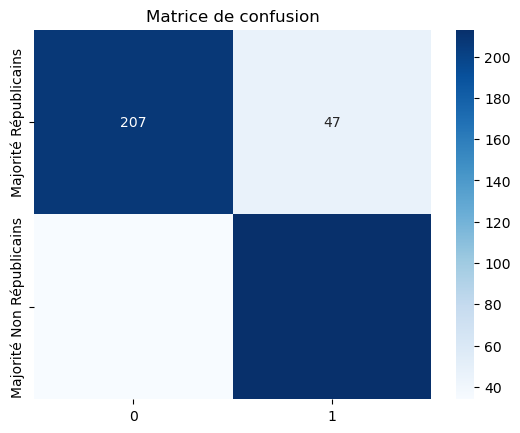

In [24]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=['Majorité Républicains', 'Majorité Non Républicains'])
plt.title('Matrice de confusion')
plt.show()

The **GridSearchCV** method searches through several parameters to find the combination that gives the best result.
The two parameters that can be easily modified are **C** and **Gamma** (in positive values).

In [25]:
param_grid = [
    {'C': [0.5, 1, 10, 100, 1000, 10000],
     'gamma': ['scale', 1, 0.1, 0.001, 0.0001],
     'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,
)
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


We can then observe a very slight modification of our results with these new parameters.

In [26]:
svm = SVC(random_state=42, C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
cm_adjusted = confusion_matrix(y_test, y_pred)
print(cm_adjusted)

[[218  36]
 [ 29 218]]


### Step 9: Analysis of results and conclusion
There are :
- 218 “true positive” contests: predicted as Republican and actually Republican
- 218 “true negative” contests: predicted as Democrat and actually Democrat
- 36 “false positive” contests: predicted as Republican but not actually so
- 29 “false-negative” contests: predicted as Democrats but are not

These results correspond to around **88.8% correct predictions**.

This shows that the factors we used could be correlated with voting trends. Further study could determine which ones carry more weight.